**An autoencoder is a neural network that learns to compress (encode) data into a low-dimensional representation and then reconstruct (decode) it back to the original. In the denoising version, it learns to remove noise from data during this process.**

# Load and Preprocess Data

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [23]:
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize pixel values to [0, 1]

The MNIST images are loaded as **28×28 grayscale images**, where each pixel has an **integer value between 0 and 255**. These represent shades of gray:

0: Black

255: White

Values in between: shades of gray

Why normalize?
*Neural networks work best when input values are small* and on a consistent scale — especially in the range** [0, 1] or [-1, 1].** This speeds up training and improves convergence.

So we convert the data type to float32 (required for neural nets) and divide by 255.0 to scale all pixel values from [0, 255] → [0.0, 1.0].

In [24]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape to (samples, 28, 28, 1)

In [25]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [26]:
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (60000, 28, 28, 1), x_test shape: (10000, 28, 28, 1)


# Gaussian noise

In [27]:
def add_noise(images, noise_factor=0.3):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy = np.clip(noisy, 0., 1.)
    return noisy

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)


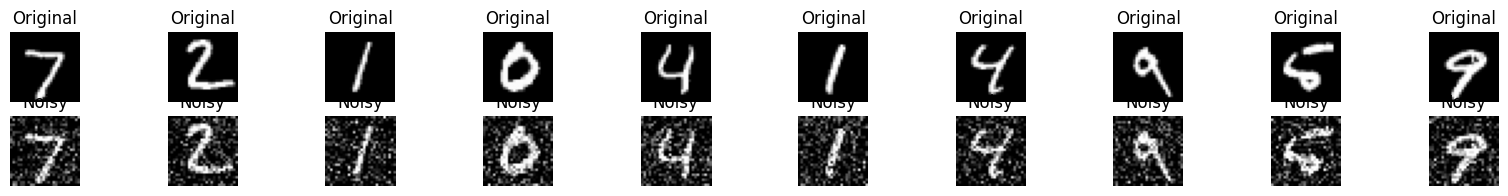

In [28]:
# Visualize
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')
plt.show()

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=25,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.2486 - val_loss: 0.0980
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0966 - val_loss: 0.0902
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0904 - val_loss: 0.0872
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0873 - val_loss: 0.0850
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0856 - val_loss: 0.0839
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0845 - val_loss: 0.0831
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0838 - val_loss: 0.0824
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0831 - val_loss: 0.0819
Epoch 9/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0826 - val_loss: 0.0815
Epoch 10/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0820 - val_loss: 0.0816
Epoch 11/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0819 - val_loss: 0.0808
Epoch 12/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/ste

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


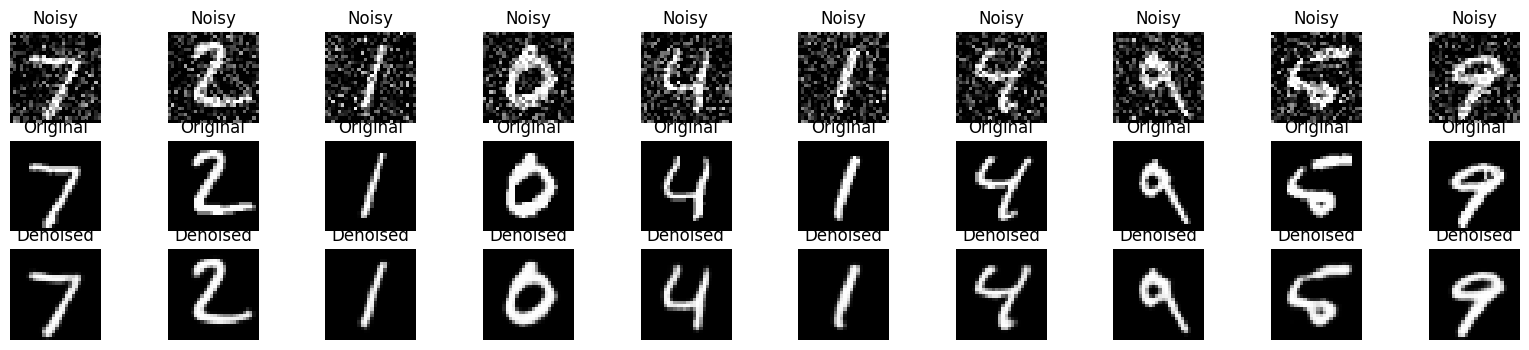

In [31]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Noisy
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Clean (Ground truth)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Denoised
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')
plt.show()


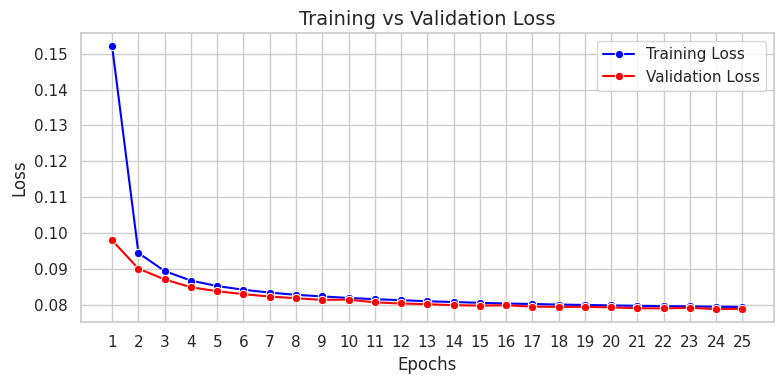

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid')

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(8, 4))
sns.lineplot(x=epochs, y=train_loss, marker='o', label='Training Loss', color='blue')
sns.lineplot(x=epochs, y=val_loss, marker='o', label='Validation Loss', color='red')

plt.title('Training vs Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(epochs)
plt.legend()
plt.tight_layout()
plt.show()
